In [ ]:
import matplotlib.pyplot as plt, numpy as np, pandas as pd, random

# Q1

The optimal score is $6$, the prefix lengths are $11$ and $12$ for the first and second sequences respectively, and the numbers of cells visited are $300$ and $4160$ with and without $X$-drop respectively.



In [ ]:
def x_drop(seq_1, seq_2, x):
  s, p, c, start = 0, (0, 0), 0, 0
  lst = np.full(len(seq_1) + 1, -np.inf); lst[0] = 0
  for i in range(1, len(lst)):
    lst[i] = lst[i - 1] - 2
    if x > 0 and lst[i] < s - x: break

  for i in range(len(seq_2)):
    tmp_1, tmp_2 = 0, 0

    for j in range(start, len(lst)):
      if j == start:
        if x > 0 and lst[j] < s - x: start += 1
        else: tmp_1 = lst[j] - 2
        continue

      y = 3 if seq_2[i] == seq_1[j - 1] else 0
      tmp_2 = max(tmp_1, lst[j - 1] + y, lst[j]) - 2
      lst[j - 1], tmp_1 = tmp_1, tmp_2

      if x > 0 and tmp_1 < s - x and (j == len(seq_1) or lst[j + 1] == -np.inf): lst[j] = tmp_1; break
      c += 1
      if tmp_1 > s: s = tmp_1; p = (i + 1, j)

  return s, p, c

seq_1 = 'GTTGATGGTCTACAACGTTATCGTCACAGCCCATGCATTTGTAATAATCTTCTTCATAGTAATA'
seq_2 = 'GATAGATGGTCTGAGCTATGATATCAATTGGCTTCCTAGGGTTTATCGTGTGAGCACACCATATT'
x_drop(seq_1, seq_2, 10)

(np.float64(6.0), (12, 11), 300)

In [ ]:
x_drop(seq_1, seq_2, 0)

(np.float64(6.0), (12, 11), 4160)

# Q2
### a)

The probability that $k$ characters from $A$ and $B$ match is $p^k$, while the probability of having matching $m$ $k$-mers on each of $A$ and $B$ follows a binomial distribution and is given by ${n+m\choose 2m}p^{k(2m)}(1-p^k)^{n-m}$, since this is equivalent to choosing $2m$ items from the bag of size $n+m$. The MLE of $p$ can then be found by maximizing the derivative of the log-likelihood function as follows:\begin{align*}
&\ell\overset{def}{=}\log\mathcal{L}(p^k|2m)=\text{constant}+2m\log p^k+(n-m)\log(1-p^k)\\
&\frac{\partial\ell}{\partial(p^k)}=\frac{2m}{p^k}-\frac{n-m}{1-p^k}\overset{set}{=}0\implies 2m(1-\hat p^k)=(n-m)\hat p^k\\
\implies&\hat p=\Big(\frac{2m}{n+m}\Big)^{1/k}
\end{align*}as needed.

### b)

The sequence similarity for the given sequences is $0.9402$, as shown below.

In [ ]:
def p_hat(seq_1, seq_2):
  bag_1, bag_2 = [], []
  for i in range(len(seq_1) - 6): bag_1.append(seq_1[i:i + 7])
  for i in range(len(seq_2) - 6): bag_2.append(seq_2[i:i + 7])
  bag_1, bag_2 = set(bag_1), set(bag_2)
  n, m = len(bag_1 | bag_2), len(bag_1 & bag_2)
  return ((2 * m) / (n + m))**(1 / 7)

seq_1 = 'CGATATAAGCAATATTATTATATTACGCCCAATAAACGATAGCTAATATGCCGCGGAGCGATCGAACCGCCCCGATAAGACCCC'
seq_2 = 'CGATATAAGCAATATTAATATATTAGCCCAATAAACGATAGCTAATATGGTGCGGAGCGATCGAACCGCCCCGAAATAAGACCCC'
p_hat(seq_1, seq_2)

0.9402491107063025

### c)

The plot of the scenarios shown below shows that $\hat p$ decreases with the number of bases inserted, and it is generally smaller if the bases were inserted into many locations compared to if they were inserted into a single location. This means that $\hat p$ is useful in practice since indels frequently occur together and not separately. When they do occur together, $\hat p$ does not decrease drastically, which is consistent with our intuition that the original and mutated sequences should still be quite similar.

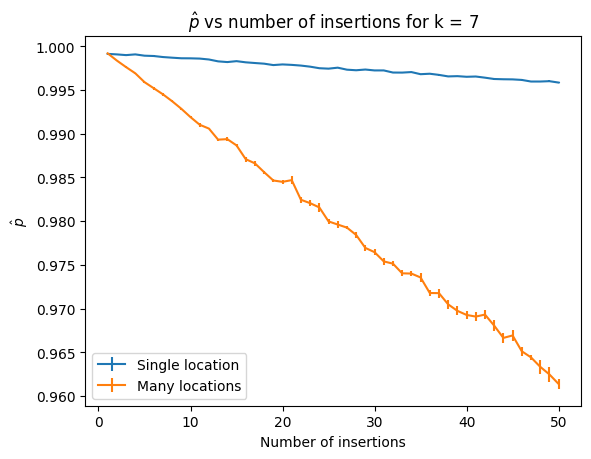

In [ ]:
n_rep, seq_len = 10, 1000
nt, ins_range = ['A', 'C', 'G', 'T'], range(1, 51)
means_1, means_2, se_1, se_2 = [], [], [], []
a = ''.join(random.choices(nt, k = seq_len))

for n_ins in ins_range:
  lst_1, lst_2 = [], []

  for i in range(n_rep):
    ins = ''.join(random.choices(nt, k = n_ins))
    b, c = a, a

    location = np.random.randint(len(a))
    b = b[:location] + ins + b[location:]
    lst_1.append(p_hat(b, a))

    locations = np.random.randint(0, len(b), n_ins)
    for j in range(n_ins): c = c[:locations[j]] + ins[j] + c[locations[j]:]
    lst_2.append(p_hat(c, a))

  means_1.append(np.mean(lst_1)); se_1.append(np.std(lst_1) / (n_rep**0.5))
  means_2.append(np.mean(lst_2)); se_2.append(np.std(lst_2) / (n_rep**0.5))

plt.errorbar(ins_range, means_1, yerr = se_1, label = 'Single location')
plt.errorbar(ins_range, means_2, yerr = se_2, label = 'Many locations')
plt.legend()
plt.title(r'$\hat p$ vs number of insertions for k = 7')
plt.xlabel('Number of insertions'); plt.ylabel(r'$\hat p$')
plt.show()

### d)

The assumption that each $7$-mer within a single sequence is unique would not hold if the sequence is $10^9$ bases long. In this case, any given $7$-mer would be likely to appear multiple times, which would cause $m$ to approach $n$ and $\hat{p}$ to approach $1$. Increasing the value of $k$ could mitigate this and improve the accuracy of $\hat p$; however, this runs the risk of making $\hat p$ more easily affected by indels.